## **Problem 1: Decoding Identities – A Frequency Domain Approach to Face Recognition**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# A.

In [2]:
DATASET_PATH = 'att_faces'
SUBJECTS     = ['s1', 's2', 's3', 's4', 's5']
TRAIN_RANGE  = range(1, 8)
TEST_RANGE   = range(8, 11)
EPS          = 1e-3

def load_images(subjects, idx_range):
    imgs, labels = [], []
    for lab, subj in enumerate(subjects):
        folder = os.path.join(DATASET_PATH, subj)
        for i in idx_range:
            img = cv2.imread(os.path.join(folder, f"{i}.pgm"), cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Cannot load {subj}/{i}.pgm")
            # Normalize to [0,1]
            img = img.astype(np.float32) / 255.0
            imgs.append(img)
            labels.append(lab)
    return np.stack(imgs), np.array(labels)

# Load training and test set
X_train, y_train = load_images(SUBJECTS, TRAIN_RANGE)
X_test,  y_test  = load_images(SUBJECTS, TEST_RANGE)
n, m = X_train.shape[1:]  # Image dimensions

In [3]:
# MACE filter computation
def compute_mace_filter(train_images):
    N = len(train_images)
    d = n * m
    u = np.ones((N, 1))

    # Construct training matrix X 
    X = np.stack([fftshift(fft2(img)).flatten() for img in train_images], axis=1)
    D_diag    = np.mean(np.abs(X)**2, axis=1) + EPS   # Estimate average power spectrum
    D_inv_vec = 1.0 / D_diag

    # Compute H     
    A = (X.T * D_inv_vec) @ X
    B = np.linalg.inv(A)
    H_vec = D_inv_vec[:, None] * (X @ (B @ u))

    H = H_vec.reshape(n, m)
    return H

Test image from subject s5 - Predicted as s2 - Decision: Unmatched (peak = 0.010)


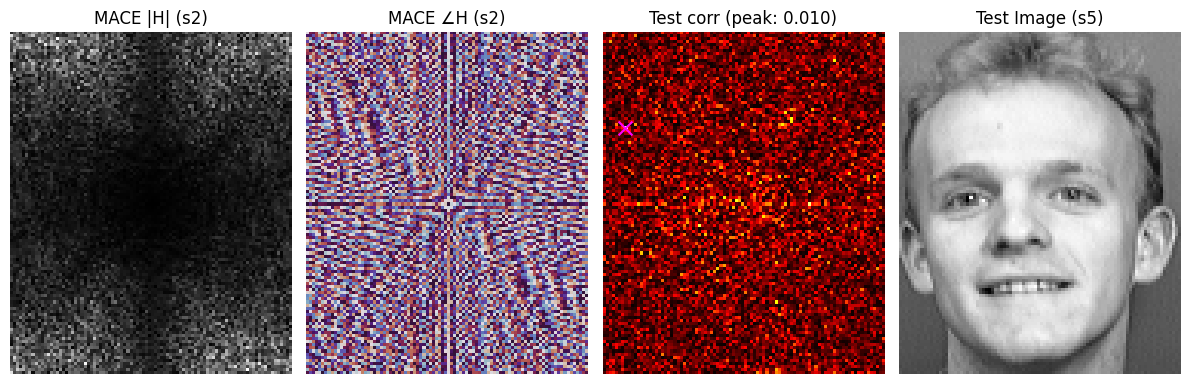

In [5]:
# Apply MACE filter to test image
def test_mace_filter(H, test_img):
    F    = fftshift(fft2(test_img))
    corr = ifft2(F * np.conj(H))
    corr = fftshift(corr)
    mag  = np.abs(corr)
    pk   = np.unravel_index(np.argmax(mag), mag.shape)
    return mag, pk, np.max(mag)

# Compute filters
filters = []
for class_idx in range(len(SUBJECTS)):
    mask = (y_train == class_idx)
    H = compute_mace_filter(X_train[mask])
    filters.append(H)

# Randomly select a test image
test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
test_label = y_test[test_idx]

peak_values = []
correlations = []
peaks = []
for class_idx, H in enumerate(filters):
    corr, pk, peak_val = test_mace_filter(H, test_img)
    correlations.append(corr)
    peaks.append(pk)
    peak_values.append(peak_val)

# Final decision based on max peak 
predicted_class = np.argmax(peak_values)
max_peak_value = peak_values[predicted_class]
is_matched = (predicted_class == test_label)

# Thresholded match decision
threshold = 0.5
if max_peak_value > threshold and is_matched:
    decision = "Matched"
else:
    decision = "Unmatched"

print(f"Test image from subject s{test_label + 1} - Predicted as s{predicted_class + 1} - Decision: {decision} (peak = {max_peak_value:.3f})")

# Show filter and correlation results for the predicted class
H_pred = filters[predicted_class]
corr_pred = correlations[predicted_class]
pk_pred = peaks[predicted_class]

plt.figure(figsize=(12, 4))

# MACE filter magnitude
plt.subplot(1, 4, 1)
plt.imshow(np.log(1 + np.abs(H_pred)), cmap='gray')
plt.title(f'MACE |H| (s{predicted_class + 1})')
plt.axis('off')

# MACE filter phase
plt.subplot(1, 4, 2)
plt.imshow(np.angle(H_pred), cmap='twilight')
plt.title(f'MACE ∠H (s{predicted_class + 1})')
plt.axis('off')

# Correlation output
plt.subplot(1, 4, 3)
plt.imshow(corr_pred, cmap='hot')
plt.scatter(pk_pred[1], pk_pred[0], c='cyan' if is_matched else 'magenta', s=100, marker='x')
plt.title(f'Test corr (peak: {max_peak_value:.3f})')
plt.axis('off')

# Test image
plt.subplot(1, 4, 4)
plt.imshow(test_img, cmap='gray')
plt.title(f'Test Image (s{test_label + 1})')
plt.axis('off')

plt.tight_layout()
plt.show()

# B.

In [ ]:
DATASET_PATH = 'att_faces'
SUBJECTS = ['s1','s2','s3','s4','s5']
TRAIN_RANGE = range(1,8)
TEST_RANGE = range(8,11)
EPS = 1e-6
NUM_CLASSES = len(SUBJECTS)

# Compute MACE filter for given training images
def compute_mace_filter(train_images):
    N = len(train_images)
    d = n * m
    u = np.ones((N,1))
    X = np.stack([fft2(img).flatten() for img in train_images], axis=1)
    D_diag = np.mean(np.abs(X)**2, axis=1) + EPS
    D_inv_vec = 1.0 / D_diag
    A = (X.T * D_inv_vec) @ X   # Matrix for filter computation
    B = np.linalg.inv(A)
    H_vec = D_inv_vec[:,None] * (X @ (B @ u))   # Filter vector in freq domain
    H = H_vec.reshape(n, m)
    H /= np.max(np.abs(H))
    return H

def test_image_with_filters(img, filters):
    responses = []
    F = fft2(img)   # DFT of test image
    for H in filters:
        corr = ifft2(F * np.conj(H))   # Cross-correlation
        corr = fftshift(corr)   
        peak = np.max(np.abs(corr))   # Peak correlation value
        responses.append(peak)
    best_class = np.argmax(responses)   # Class with max peak
    return best_class, max(responses)

# Build MACE filters for all classes
filters = []
for cls in range(NUM_CLASSES):
    class_imgs = X_train[y_train == cls]
    H_cls = compute_mace_filter(class_imgs)
    filters.append(H_cls)

correct = 0
for i in range(len(X_test)):
    test_img = X_test[i]
    true_label = y_test[i]
    predicted_label, peak = test_image_with_filters(test_img, filters)
    matched = (predicted_label == true_label)
    if matched:
        correct += 1
    print(f"Test #{i+1:2d} | True: {true_label} - Pred: {predicted_label} | Peak: {peak:.3f} | {'✔' if matched else '✘'}")

# Print overall recognition rate
total = len(X_test)
accuracy = correct / total
print(f"\n Recognition Rate: {accuracy*100:.2f}% ({correct}/{total})")

Test # 1 | True: 0 - Pred: 4 | Peak: 5.752 | ✘
Test # 2 | True: 0 - Pred: 0 | Peak: 5.944 | ✔
Test # 3 | True: 0 - Pred: 1 | Peak: 6.279 | ✘
Test # 4 | True: 1 - Pred: 1 | Peak: 23.137 | ✔
Test # 5 | True: 1 - Pred: 1 | Peak: 11.179 | ✔
Test # 6 | True: 1 - Pred: 1 | Peak: 20.602 | ✔
Test # 7 | True: 2 - Pred: 2 | Peak: 10.816 | ✔
Test # 8 | True: 2 - Pred: 2 | Peak: 8.180 | ✔
Test # 9 | True: 2 - Pred: 0 | Peak: 7.618 | ✘
Test #10 | True: 3 - Pred: 0 | Peak: 7.679 | ✘
Test #11 | True: 3 - Pred: 1 | Peak: 7.577 | ✘
Test #12 | True: 3 - Pred: 3 | Peak: 5.146 | ✔
Test #13 | True: 4 - Pred: 2 | Peak: 6.287 | ✘
Test #14 | True: 4 - Pred: 4 | Peak: 6.011 | ✔
Test #15 | True: 4 - Pred: 0 | Peak: 7.237 | ✘

 Recognition Rate: 53.33% (8/15)
